In [1]:
import matplotlib.pyplot as plt
import torch
import argparse
import os
import cv2
import sys
import numpy as np
from collections import OrderedDict
from models import get_model
import math

# Test Segmentation

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
def convert_state_dict(state_dict):
    """Converts a state dict saved from a dataParallel module to normal
       module state_dict inplace
       :param state_dict is the loaded DataParallel model_state
    """
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    return new_state_dict
def decode_segmap(temp,label_colours):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, 19):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb
def init_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_classes = 19
    # Setup Model
    model = get_model({"arch": "hardnet"}, n_classes)
    state = convert_state_dict(torch.load(model_path, map_location=device)["model_state"])
    model.load_state_dict(state)
    model.eval()
    model.to(device)
    return device, model

In [4]:
def process_img(img, size, device, model, is_driveable_area = False):
    #print("Read Input Image from : {}".format(img_path))

    img_resized = cv2.resize(img, (int(size[1]), int(size[0])))  # uint8 with RGB mode
    img = img_resized.astype(np.float16)

    # norm
    value_scale = 255
    mean = [0.406, 0.456, 0.485]
    mean = [item * value_scale for item in mean]
    std = [0.225, 0.224, 0.229]
    std = [item * value_scale for item in std]
    img = (img - mean) / std

    # NHWC -> NCHW
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img).float()

    images = img.to(device)
    outputs = model(images)
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]
    colors2 = [  # [  0,   0,   0],
        [125, 125, 125],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    if is_driveable_area:
        label_colours = dict(zip(range(19), colors2))
    else:
        label_colours = dict(zip(range(19), colors))
                   
    print('Output shape: ',outputs.shape)
    pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    #print(pred.shape)
    decoded = decode_segmap(temp=pred,label_colours=label_colours)
    #print(img_resized.shape)
    #print(decoded.shape)
    
    return decoded

In [5]:
def plot_segmendet_image(img, img_decoded):
    image=img.astype(np.float32)/255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    original = cv2.resize(original,(img_decoded.shape[1], img_decoded.shape[0]))
    plt.imshow(np.concatenate((original, img_decoded), axis=0))
    plt.show()


In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        #print(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

Output shape:  torch.Size([1, 19, 720, 1080])


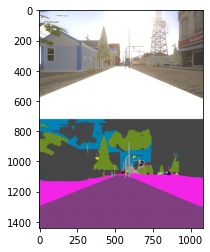

In [7]:
images_path = './data'
device,model = init_model("pretrained/hardnet70_cityscapes_model.pkl")
img_test = cv2.imread("./data/dolly.png")
h,w,_ = img_test.shape

img_decoded = process_img(img_test,[h,w],device,model.cuda())
plot_segmendet_image(img_test, img_decoded)

# Warp Image

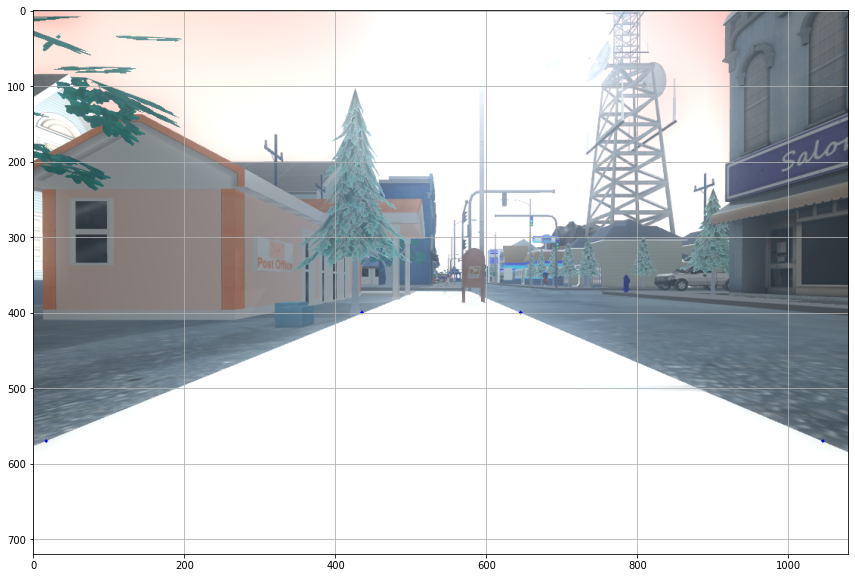

In [8]:

margin_h = 100
margin_w = 100
width = 480
height = 480
img_size = (width, height)
## These points would be normally found by extrinsic callibration (here they were chosen by just looking at the image)
src = np.float32([[435,400], [645,400],[1045,570], [17, 570]])
dst = np.float32([[margin_w,margin_h],[width-margin_w,margin_h],[width-margin_w,height],[margin_w,height]])
# Show calibration points in image
img = img_test.copy()
for point in src:
    cv2.circle(img,(point[0],point[1]), 2, (0,0,255), -1)
    
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img)
ax.grid(True)
plt.show()

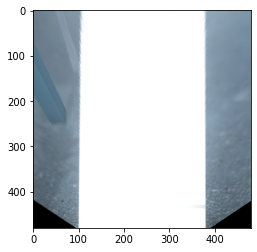

Testing on a different image


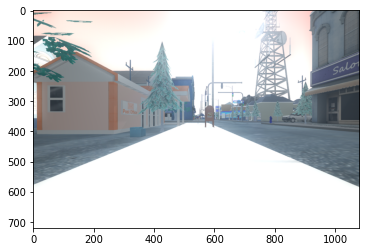

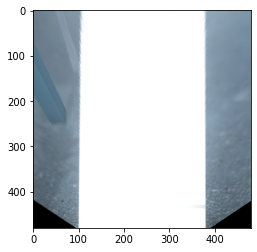

In [19]:
# Find transformation
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

# Save Transforms
np.savez('PerspectiveTransform.npz', M=M, M_inv=M_inv)
warped = cv2.warpPerspective(img_test, M, img_size, flags=cv2.INTER_LINEAR)
#Calculae pixel per meter
pixel_per_meter_x = (width - 2*margin_w)/2.7 #Horizontal distance between src points in the real world ( I assumed 4 meters)
pixel_per_meter_y = (height - 2*margin_h)/8.0 #Vertical distance between src points in the real world ( I assumed 20 meters)

plt.imshow(warped)
plt.show()

## Try perspective transformation on another image
warped2 = cv2.warpPerspective(img_test, M, img_size, flags=cv2.INTER_LINEAR)
print("Testing on a different image")
plt.imshow(img_test)
plt.show()
plt.imshow(warped2)
plt.show()

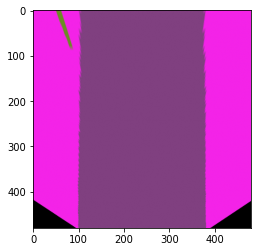

In [20]:
# Warped Segmented 
warped_seg = cv2.warpPerspective(img_decoded, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped_seg)
plt.show()

### Let's try to find the limits of the driveable areas

Output shape:  torch.Size([1, 19, 720, 1080])


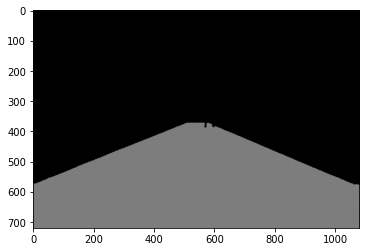

In [21]:
# get driveable area
driveable_area_decoded = process_img(img_test,[h,w],device,model.cuda(), True)
plt.imshow(driveable_area_decoded)
plt.show()

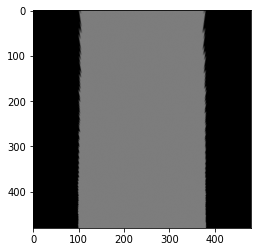

In [22]:
# Transform driveable area and extract a mask
driveable_warped = cv2.warpPerspective(driveable_area_decoded, M, img_size, flags=cv2.INTER_LINEAR)
lower_limit = np.array([50,50,50])
upper_limit = np.array([200, 200, 200])
mask = cv2.inRange(np.uint8(driveable_warped*255), lower_limit, upper_limit)
plt.imshow(driveable_warped)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


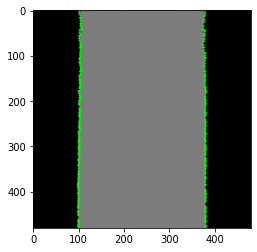

In [23]:
contours, hierarchy = cv2.findContours(mask*200,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_warped = driveable_warped.copy()
for contour in contours:
        cv2.drawContours(contours_warped, contour, -1, (0, 255, 0), 3)
plt.imshow(contours_warped)
plt.show()

### Now we'll use the contours to find the points a 2D Lidar would see, we'll assume the lidar is mounted at the center of the image

In [24]:
# Calculate the center of the image and transform to warped image to know where the camera and hence the
# virtual lidar are located
#dead_zone = 0.55866615094
height, width, _ = img.shape
original_center = np.array([[[width/2,height]]],dtype=np.float32)
warped_center = cv2.perspectiveTransform(original_center, M)[0][0]
warped_center[1] = warped_center[1] + 0.0*pixel_per_meter_y # Assume 50cm of view deadzone (value to be found with propper extrinsic calibration)

warped_center

array([242.71095, 520.2407 ], dtype=float32)

In [25]:
pixel_per_meter_x

325.9259259259259

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


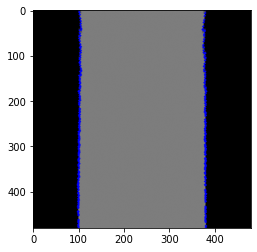

598

In [26]:
contours_warped = driveable_warped.copy()
scan_distances = []
scan_angles = []
for contour in contours:
    for point in contour:
        distance = math.sqrt(((point[0][0]-warped_center[0])/pixel_per_meter_x)**2 + ((point[0][1]-warped_center[1])/pixel_per_meter_y)**2)
        angle = math.atan2((point[0][0] - warped_center[0])/pixel_per_meter_x, (warped_center[1]-point[0][1])/pixel_per_meter_y)
        scan_distances.append(distance)
        scan_angles.append(angle)
        cv2.circle(contours_warped,(point[0][0],point[0][1]), 2, (0,0,255), -1)
plt.imshow(contours_warped)
plt.show()
len(scan_distances)

In [27]:
## arrange data
# take second element for sort
def takeSecond(elem):
    return elem[1]
scan_array = np.float32(([scan_distances, scan_angles])).T
scan_list = list(scan_array)
scan_list.sort(key=takeSecond)
scan_array = np.array(scan_list)
print(scan_array.shape)

(598, 2)


### Plot "scan data"

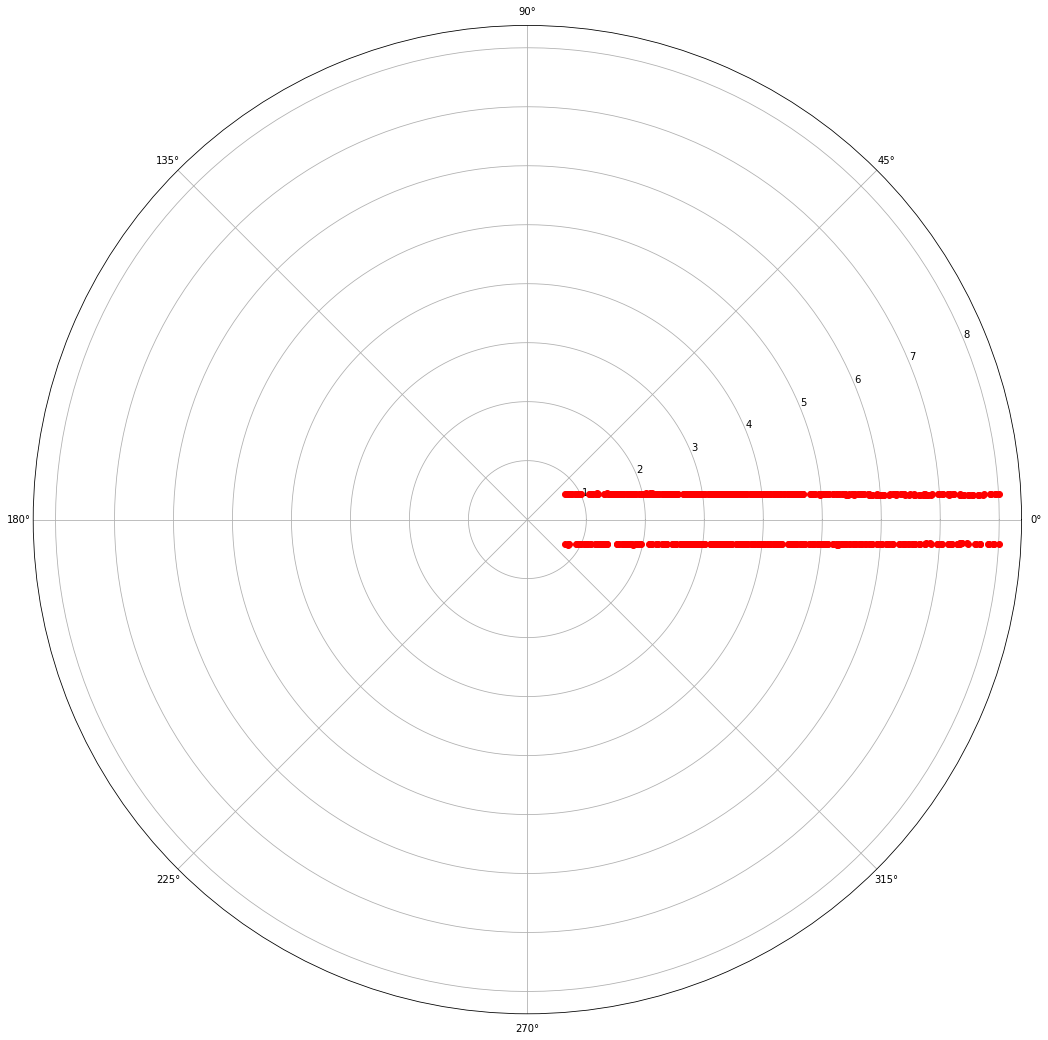

In [28]:
fig = plt.figure(figsize=(20, 40))
ax = plt.subplot(2, 1, 2, projection='polar')
for p, theta in scan_list:
    plt.polar(-theta, p, 'ro') #invert the angle just for visualization purposes
plt.show()

### Subsample to fulfill 2 conditions: Have always the same number of points and have an equal angle between points

In [43]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [44]:
angle_range = [-50, 50]
angle_increment = 1
scan_distances = []
scan_angles = []
for angle in range(angle_range[0], angle_range[1], angle_increment):
    rads = angle*math.pi/180.0
    scan_angles.append(rads)
    idx = find_nearest_idx(scan_array[:,1], rads)
    scan_distances.append(scan_array[idx,0])
    #Search for element


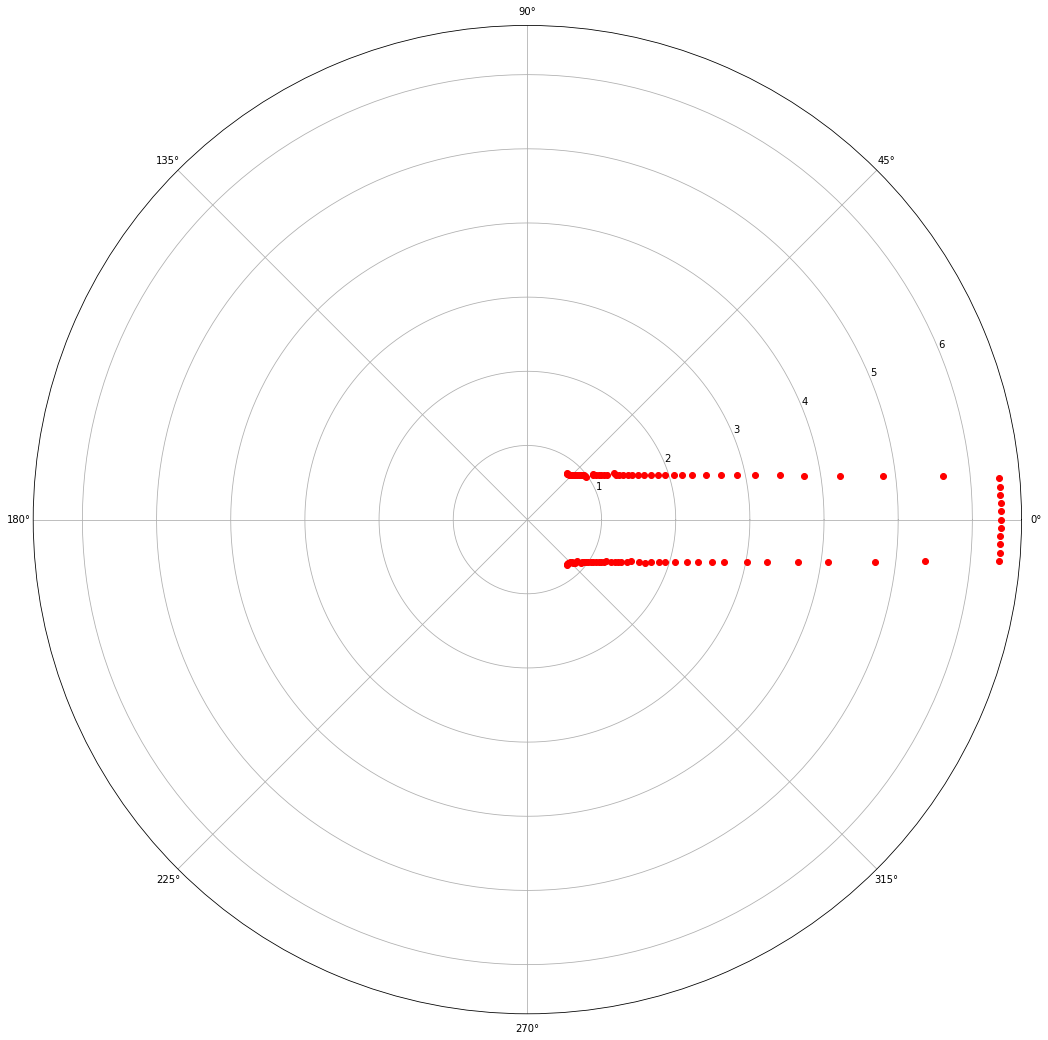

In [45]:
fig = plt.figure(figsize=(20, 40))
ax = plt.subplot(2, 1, 2, projection='polar')
for p, theta in zip(scan_distances,scan_angles):
    plt.polar(-theta, p, 'ro') #invert the angle just for visualization purposes
plt.show()